In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import patsy
import re
import requests
import scipy.stats as stats
import seaborn as sns
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from sklearn import metrics
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import KFold
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import RidgeCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
import statsmodels.api as sm
import statsmodels.formula.api as smf
%matplotlib inline

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
ea = pd.read_csv('educational_attainment.csv')
ei = pd.read_csv('education_income_simple.csv')
df = pd.merge(ei, ea, on='county')
df['he_pct'] = ((df['ba']+df['ma'])/df['pop'])*100
df['le_income'] = (df['lh_income'] * ((df['less_hs'] + df['some_hs']) / df['pop']) + df['hs_income'] * (df['hs'] / df['pop']) + df['aa_income'] * ((df['sc'] + df['aa']) / df['pop'])) / ((df['less_hs'] + df['some_hs'] + df['hs'] + df['sc'] + df['aa']) / df['pop'])
df['he_income'] = ((df['ba_income'] * (df['ba'] / df['pop'])) + (df['ma_income'] * (df['ma'] / df['pop']))) / ((df['ba'] + df['ma']) / df['pop'])
ind = pd.read_csv('economic_industry.csv')
ind['industrial'] = ind['mining'] + ind['construction'] + ind['manufacturing']
ind['service'] = ind['employed'] - ind['agricultural'] - ind['industrial']
ind['ag_pct'] = (ind['agricultural'] / ind['employed']) * 100
ind['ind_pct'] = (ind['industrial'] / ind['employed']) * 100
ind['svc_pct'] = (ind['service'] / ind['employed']) * 100
ind1 = ind[['county', 'employed', 'ag_pct', 'ind_pct', 'svc_pct']]
df1 = pd.merge(df, ind1, on='county')
ce = pd.read_csv('county_employers.csv')
df2 = pd.merge(df1, ce, on='county')
df2['popest'] = df2['pop']/df2['establishments']
lf = pd.read_csv('education_laborforce.csv')
lf['lelf'] = ((lf['lhlf'] + lf['hslf'] + lf['sclf'])/(lf['pop2564']-lf['bapop']))*100
lf['leue'] = ((lf['lhue'] + lf['hsue'] + lf['scue'])/(lf['lhlfc'] + lf['hslfc'] + lf['sclfc']))*100
lf['helf'] = (lf['balf']/lf['bapop']) * 100
lf['heue'] = (lf['baue']/lf['balfc']) * 100
lf = lf[['county', 'lelf', 'leue', 'helf', 'heue']]
df3 = pd.merge(df2, lf, on='county')
mw = pd.read_csv('county_minwage.csv')
df4 = pd.merge(df3,mw,on='county')
df4 = df4[['le_income', 'he_pct', 'he_income', 'ag_pct', 'ind_pct', 'popest', 'lelf', 'leue', 'helf', 'heue', 'wage']]

In [3]:
y, x = patsy.dmatrices('le_income ~ he_pct + he_income + ag_pct + ind_pct + popest + lelf + leue + helf + heue + wage', data=df4)
model = sm.OLS(y, x)
fit = model.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              le_income   R-squared:                       0.608
Model:                            OLS   Adj. R-squared:                  0.606
Method:                 Least Squares   F-statistic:                     460.1
Date:                Thu, 24 Jan 2019   Prob (F-statistic):               0.00
Time:                        14:34:20   Log-Likelihood:                -27750.
No. Observations:                2983   AIC:                         5.552e+04
Df Residuals:                    2972   BIC:                         5.559e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    638.2606   1028.247      0.621      0.535   -1377.888    2654.409
he_pct        29.0147      9.057      3.204      0.001      11.257      46.772
he_income      0.2413      0.008     31.005      0.000       0.226       0.257
ag_pct       -13.8823     11.112     -1.249      0.212     -35.669       7.905
ind_pct       66.7809      9.449      7.068      0.000      48.254      85.308
popest        36.1810      4.764      7.595      0.000      26.841      45.521
lelf         147.5881      8.639     17.085      0.000     130.650     164.526
leue        -385.5755     19.784    -19.489      0.000    -424.367    -346.784
helf          24.4927     10.986      2.229      0.026       2.952      46.033
heue         -22.8790     27.803     -0.823      0.411     -77.394      31.636
wage         430.5952     65.246      6.600      0.000     302.663     558.528
==============================================================================
Omnibus:                      413.515   Durbin-Watson:                   2.045
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1270.857
Skew:                           0.714   Prob(JB):                    1.09e-276
Kurtosis:                       5.861   Cond. No.                     1.01e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.01e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [4]:
lr = LinearRegression()
X = df4[['he_pct', 'he_income', 'ag_pct', 'ind_pct', 'popest', 'lelf', 'leue', 'helf', 'heue', 'wage']]
y = df4['le_income']
lr.fit(X, y)
lr.score(X, y)

0.6075415735665364

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)
lr.fit(X_train, y_train)
lr.score(X_test, y_test)

0.58866905077295

In [6]:
lr = LinearRegression()
scores = cross_val_score(lr, X, y, cv=10, scoring='mean_squared_error')

print('Mean squared error for each cross-val:',scores,'\n')
print('Mean squared error of all cross vals:',np.mean(scores),'+-',np.std(scores))

Mean squared error for each cross-val: [-12445396.86219262  -7862769.09322891  -7230997.98088404
  -5877124.77740703  -5093136.91481625  -4583995.66024417
  -5985163.12133016  -6257899.54072709  -6939582.40125251
  -9894364.4404101 ] 

Mean squared error of all cross vals: -7217043.079249288 +- 2251103.194495082


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/m

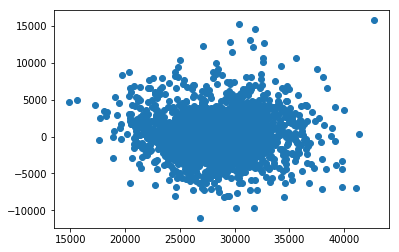

In [7]:
lr.fit(X, y)
df4['predict'] = lr.predict(X)
df4['residual'] = df4['le_income'] - df4['predict']
p = df4['predict']
r = df4['residual']
plt.scatter(p,r);

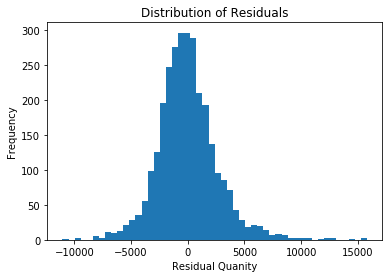

In [8]:
plt.hist(r, bins=50)
plt.title("Distribution of Residuals")
plt.xlabel("Residual Quanity")
plt.ylabel("Frequency");

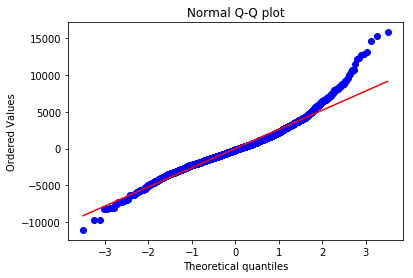

In [9]:
stats.probplot(r, dist="norm", plot=plt)
plt.title("Normal Q-Q plot");

In [10]:
ri = RidgeCV(alphas=(0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0))
rifit = ri.fit(X, y)
rifit.score(X, y)

0.6075415703927805

In [11]:
la = Lasso(alpha=1)
lafit = la.fit(X, y)
lafit.score(X, y)

0.607541423526521

In [12]:
scores = cross_val_score(ri, X, y, cv=10, scoring='mean_squared_error')
print('MSE for each cross-val:',scores,'\n')
print('MSE of all cross vals:',np.mean(scores),'+-',np.std(scores))

MSE for each cross-val: [-12445570.76093277  -7862816.99329656  -7230837.70691416
  -5877167.95594783  -5093065.79535919  -4583829.2591469
  -5985254.64214357  -6257892.00731589  -6939565.92267539
  -9893935.20159371] 

MSE of all cross vals: -7216993.624532597 +- 2251112.9323971937


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/m

In [13]:
scores = cross_val_score(la, X, y, cv=10, scoring='mean_squared_error')
print('MSE for each cross-val:',scores,'\n')
print('MSE of all cross vals:',np.mean(scores),'+-',np.std(scores))

MSE for each cross-val: [-12445389.48208726  -7863504.80903178  -7230137.38943256
  -5877326.38737245  -5092547.04591226  -4583454.53972835
  -5985734.24288684  -6258005.41530924  -6939063.65450789
  -9893897.79041923] 

MSE of all cross vals: -7216906.075668785 +- 2251144.1835588366


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/m

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)
ri.fit(X_train, y_train)
#print(lr.score(X_train, y_train))
print(lr.score(X_test, y_test))

0.58866905077295


In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)
la.fit(X_train, y_train)
#print(lr.score(X_train, y_train))
print(lr.score(X_test, y_test))

0.58866905077295


In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)
lr.fit(X_train, y_train)
lr.score(X_test, y_test)

0.58866905077295

In [33]:
lr.score(X_train, y_train)

0.6143003095030592

In [29]:
from sklearn.ensemble import GradientBoostingRegressor
gbrt = GradientBoostingRegressor().fit(X_train, y_train)
y_test_pred_gb = gbrt.predict(X_test)
y_train_pred_gb = gbrt.predict(X_train)
gbrt.score(X_test, y_test)

0.6100000460530508

In [32]:
gbrt.score(X_train, y_train)

0.7850866193182353

In [30]:
from sklearn.ensemble import RandomForestRegressor
rfrt = RandomForestRegressor().fit(X_train, y_train)
y_test_pred_rf = rfrt.predict(X_test)
y_train_pred_rf = rfrt.predict(X_train)
rfrt.score(X_test, y_test)

0.5544514332719122

In [31]:
rfrt.score(X_train, y_train)

0.9280149916925012